In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout, GRU
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lottoMainFunctions as mf

from tensorflow.keras.callbacks import ReduceLROnPlateau


In [83]:
import importlib as i

In [4]:
i.reload(mf)

<module 'lottoMainFunctions' from 'D:\\GITHUB\\Mounika-Tarsasjatek\\Lotto2\\lottoMainFunctions.py'>

In [73]:
tip =  "ötös", 5
df, dfRaw = mf.getLotto(mf.getLottoDB(tip[0]), type=tip[0])
Years = 30
# cut
dfRaw = dfRaw[0:(Years*52)]

# One Hot Encoder

In [46]:
one_hot_encoded = tf.one_hot(dfRaw, depth=90)
transformed_array = tf.reduce_max(one_hot_encoded, axis=1)
transformed_array[1+14:1+14+1,0:5]

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=array([[0., 0., 0., 0., 0.]], dtype=float32)>

In [70]:
transformed_array[0]

<tf.Tensor: shape=(90,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.], dtype=float32)>

In [67]:
df.shape[0]

3471

In [72]:
dfRaw[0]

array([51, 61, 63, 67, 75], dtype=int64)

# No encoder

In [78]:
transformed_array = dfRaw
LOTTOSIZE = 5

# MinMaxScalar

In [74]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()
LOTTOSIZE = 5
transformed_array = scaler.fit_transform(dfRaw)

## Prepare training

In [75]:
window_length = 21 # weeks
# Balls counts
number_of_features = tip[1] # how many ball, 5, 6 
number_of_rows = transformed_array.shape[0]

In [76]:
i = 10
transformed_array[i : i + window_length]

array([[0.0483871 , 0.19480519, 0.61842105, 0.7027027 , 0.98360656],
       [0.27419355, 0.51948052, 0.47368421, 0.44594595, 0.93442623],
       [0.38709677, 0.44155844, 0.39473684, 0.48648649, 0.98360656],
       [0.17741935, 0.45454545, 0.55263158, 0.7972973 , 0.78688525],
       [0.37096774, 0.32467532, 0.55263158, 0.52702703, 0.68852459],
       [0.4516129 , 0.42857143, 0.36842105, 0.44594595, 0.8852459 ],
       [0.22580645, 0.31168831, 0.27631579, 0.47297297, 0.67213115],
       [0.        , 0.23376623, 0.44736842, 0.37837838, 0.54098361],
       [0.5483871 , 0.48051948, 0.94736842, 0.98648649, 1.        ],
       [0.09677419, 0.11688312, 0.09210526, 0.54054054, 0.73770492],
       [0.09677419, 0.14285714, 0.26315789, 0.43243243, 0.47540984],
       [0.14516129, 0.19480519, 0.22368421, 0.2027027 , 0.8852459 ],
       [0.22580645, 0.32467532, 0.60526316, 0.63513514, 0.7704918 ],
       [0.29032258, 0.46753247, 0.59210526, 0.58108108, 0.68852459],
       [0.08064516, 0.09090909, 0.

In [77]:
X = np.empty([number_of_rows - window_length, window_length, LOTTOSIZE], dtype=float)
y = np.empty([number_of_rows - window_length, LOTTOSIZE], dtype=float)

for i in range(0, number_of_rows - window_length):
    #X[i] = transformed_df.iloc[i : i + window_length, 0 : number_of_features].values
    #y[i] = transformed_df.iloc[i + window_length : i + window_length + 1, 0 : number_of_features].values
    X[i] = transformed_array[i : i + window_length, 0 : LOTTOSIZE]
    #X[i] = transformed_array[i : i + window_length]
    y[i] = transformed_array[i + window_length : i + window_length + 1, 0 : LOTTOSIZE]
    # y[i] = transformed_array[i + window_length : i + window_length + 1]

# Focal LOSS

In [83]:

BATCH_SIZE = 100 # 100
biDirectionalNeurons = 90*1 # 
EPOCHS = 100 # 100

model = Sequential()
model.add(Bidirectional(LSTM(biDirectionalNeurons, input_shape = (window_length, LOTTOSIZE), return_sequences = True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(biDirectionalNeurons, input_shape = (window_length, LOTTOSIZE), return_sequences = True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(biDirectionalNeurons, input_shape = (window_length, LOTTOSIZE), return_sequences = True)))
model.add(Bidirectional(LSTM(biDirectionalNeurons, input_shape = (window_length, LOTTOSIZE), return_sequences = False)))
#model.add(Dense(90))
model.add(Dense(LOTTOSIZE,activation='sigmoid'))

def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        pt = y_pred * y_true + (1 - y_pred) * (1 - y_true)
        focal_loss = -alpha * (1 - pt)**gamma * tf.math.log(pt + 1e-7)
        return tf.reduce_mean(focal_loss)
    return focal_loss_fixed


#model.compile(optimizer=Adam(learning_rate=0.0001), loss ='categorical_crossentropy', metrics=['accuracy'])
# Compile the model with focal loss
model.compile(optimizer=Adam(learning_rate=0.0001), loss=focal_loss(), metrics=['accuracy'])

# history = model.fit(x=X, y=y, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=2)

# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=[0, 1], y=y.flatten())

# Fit the model with class weights
history = model.fit(x=X, y=y, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=2, class_weight=dict(enumerate(class_weights)))

ValueError: classes should include all valid labels that can be in y

# NN1

In [40]:
LOTTOSIZE
from tensorflow.keras.callbacks import TensorBoard


Epoch 1/50
16/16 - 6s - loss: 0.6776 - accuracy: 0.0643 - lr: 1.0000e-04 - 6s/epoch - 353ms/step
Epoch 2/50
16/16 - 0s - loss: 0.6724 - accuracy: 0.2814 - lr: 1.0000e-04 - 354ms/epoch - 22ms/step
Epoch 3/50
16/16 - 0s - loss: 0.6670 - accuracy: 0.6836 - lr: 1.0000e-04 - 365ms/epoch - 23ms/step
Epoch 4/50
16/16 - 0s - loss: 0.6613 - accuracy: 0.7563 - lr: 1.0000e-04 - 374ms/epoch - 23ms/step
Epoch 5/50
16/16 - 0s - loss: 0.6549 - accuracy: 0.7563 - lr: 1.0000e-04 - 357ms/epoch - 22ms/step
Epoch 6/50
16/16 - 0s - loss: 0.6509 - accuracy: 0.7563 - lr: 1.0000e-05 - 368ms/epoch - 23ms/step
Epoch 7/50
16/16 - 0s - loss: 0.6503 - accuracy: 0.7563 - lr: 1.0000e-05 - 367ms/epoch - 23ms/step
Epoch 8/50
16/16 - 0s - loss: 0.6496 - accuracy: 0.7563 - lr: 1.0000e-05 - 363ms/epoch - 23ms/step
Epoch 9/50
16/16 - 0s - loss: 0.6490 - accuracy: 0.7563 - lr: 1.0000e-05 - 368ms/epoch - 23ms/step
Epoch 10/50
16/16 - 0s - loss: 0.6483 - accuracy: 0.7563 - lr: 1.0000e-05 - 371ms/epoch - 23ms/step
Epoch 11/50

<module 'matplotlib.pyplot' from 'C:\\Users\\Gergo Gyori\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\matplotlib\\pyplot.py'>

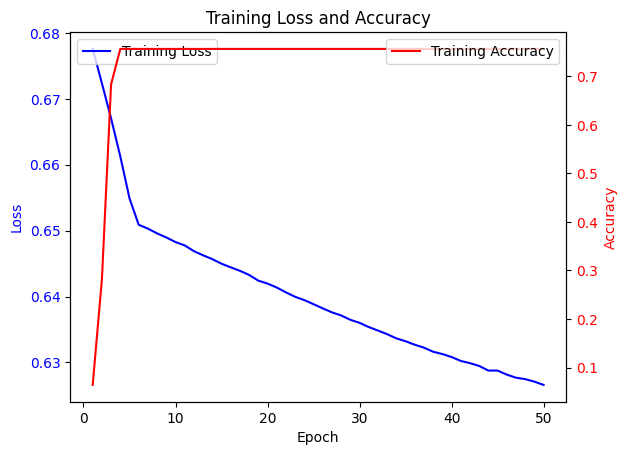

In [91]:
BATCH_SIZE = 100 # 100
biDirectionalNeurons = 25 # We can play with this. 
EPOCHS = 50 # 100
#%tensorboard --logdir logs  # Specify the same log directory path as used in the callback

model = Sequential()

model.add(Bidirectional(GRU(4, return_sequences=True), input_shape=(window_length, LOTTOSIZE)))
#model.add(Bidirectional(LSTM(biDirectionalNeurons, input_shape = (window_length, LOTTOSIZE), return_sequences = True)))
#model.add(Dropout(0.2))
#model.add(Bidirectional(LSTM(biDirectionalNeurons, input_shape = (window_length, LOTTOSIZE), return_sequences = True)))
#model.add(Dropout(0.2))
#model.add(Bidirectional(LSTM(biDirectionalNeurons, input_shape = (window_length, LOTTOSIZE), return_sequences = True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(biDirectionalNeurons, input_shape = (window_length, LOTTOSIZE), return_sequences = False)))
#model.add(Dense(90))
model.add(Dense(tip[1],activation='sigmoid'))

reduce_lr = ReduceLROnPlateau(monitor='accuracy', 
                              factor=0.1, 
                              patience=1, 
                              min_lr=0.00001)

#model.compile(optimizer=Adam(learning_rate=0.0001), loss ='categorical_crossentropy', metrics=['accuracy']) #for binary numbers
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy']) # for whatever reasones
#model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['accuracy']) # for numbers between 0 nad 90

#log_dir = "logs"  # Replace with your desired log directory path
#tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

#%tensorboard --logdir logs  # Specify the same log directory path as used in the callback

history = model.fit(x=X, y=y, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=2, callbacks=[reduce_lr])

X_sample = X[0].reshape(1, window_length, tip[1])
print(model.predict(X_sample))

mf.plotTrainingHistory(history)

In [50]:
transformed_array[0:14]

array([[0.03225806, 0.31343284, 0.24657534, 0.55555556, 0.94915254],
       [0.80645161, 0.86567164, 0.7260274 , 0.70833333, 0.74576271],
       [0.12903226, 0.64179104, 0.50684932, 0.625     , 0.93220339],
       [0.09677419, 0.07462687, 0.05479452, 0.05555556, 0.27118644],
       [0.33870968, 0.64179104, 0.5890411 , 0.55555556, 0.61016949],
       [0.24193548, 0.92537313, 0.79452055, 0.75      , 1.        ],
       [0.        , 0.01492537, 0.31506849, 0.375     , 0.57627119],
       [0.14516129, 0.28358209, 0.17808219, 0.47222222, 0.50847458],
       [0.30645161, 0.32835821, 0.2739726 , 0.26388889, 0.71186441],
       [0.41935484, 0.79104478, 0.89041096, 0.83333333, 0.84745763],
       [0.0483871 , 0.20895522, 0.61643836, 0.70833333, 0.98305085],
       [0.27419355, 0.58208955, 0.46575342, 0.44444444, 0.93220339],
       [0.38709677, 0.49253731, 0.38356164, 0.48611111, 0.98305085],
       [0.17741935, 0.50746269, 0.54794521, 0.80555556, 0.77966102]])

In [72]:
dfRaw[0:21]

array([[ 3, 24, 28, 56, 87],
       [51, 61, 63, 67, 75],
       [ 9, 46, 47, 61, 86],
       [ 7,  8, 14, 20, 47],
       [22, 46, 53, 56, 67],
       [16, 65, 68, 70, 90],
       [ 1,  4, 33, 43, 65],
       [10, 22, 23, 50, 61],
       [20, 25, 30, 35, 73],
       [27, 56, 75, 76, 81],
       [ 4, 17, 55, 67, 89],
       [18, 42, 44, 48, 86],
       [25, 36, 38, 51, 89],
       [12, 37, 50, 74, 77],
       [24, 27, 50, 54, 71],
       [29, 35, 36, 48, 83],
       [15, 26, 29, 50, 70],
       [ 1, 20, 42, 43, 62],
       [35, 39, 80, 88, 90],
       [ 7, 11, 15, 55, 74],
       [ 7, 13, 28, 47, 58]], dtype=int64)

In [100]:
LASTHOWMANYLOTTO = 42
X_sample = transformed_array[0:LASTHOWMANYLOTTO].reshape(1, LASTHOWMANYLOTTO, tip[1])

In [101]:
#X_sample = X[0].reshape(1, 21, tip[1])
#model.predict(transformed_array[0:14])
scaler.inverse_transform(model.predict(X_sample))

1/1 [==============================] - 0s 23ms/step


array([[18.605919, 29.562716, 47.82006 , 59.337074, 73.06934 ]],
      dtype=float32)

In [32]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

# Assuming you have already created and compiled your model
# model = ...

# Plot the model structure and display it
plot_model(model, show_shapes=True, show_layer_names=True)

# Show the plot
plt.show()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [36]:
from keras.utils import plot_model

# Assuming you have already created and compiled your model
# model = ...

# Specify the file name for saving the visualization
plot_file = "model_structure.png"

# Plot and save the model structure to a file
plot_model(model, to_file=plot_file, show_shapes=True, show_layer_names=True)

# Display the saved plot using a library like matplotlib
import matplotlib.pyplot as plt
img = plt.imread(plot_file)
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


FileNotFoundError: [Errno 2] No such file or directory: 'model_structure.png'

In [35]:
import keras.utils

In [31]:
%load_ext tensorboard
import tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [123]:
import numpy as np
from keras.models import Sequential
from keras.layers import Bidirectional, GRU, Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming you have already loaded and preprocessed your data into X and y
# X should be in the shape: (number_of_samples, window_length, number_of_features)
# y should be in the shape: (number_of_samples, number_of_features)

model = Sequential()
model.add(Bidirectional(GRU(45, return_sequences=True), input_shape=(window_length, LOTTOSIZE)))
model.add(Bidirectional(GRU(45, return_sequences=True)))
model.add(Bidirectional(GRU(4, return_sequences=True)))
model.add(Dense(tip[1], activation='linear'))  # Use 'linear' activation for regression

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mean_absolute_error'])

# Fit the model
#history = model.fit(x=X, y=y, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=2)

# Make a prediction
X_sample = X[0].reshape(1, window_length, tip[1])
predictions = model.predict(X_sample)

print(predictions)


1/1 [==============================] - 2s 2s/step
[[[ 0.7176677   0.35877034 -0.05154084  0.59601676  0.910071  ]
  [ 0.8360099   0.08457763 -0.12732844  0.5612186   0.97027487]
  [ 0.9107233  -0.07855833 -0.11235988  0.45339745  0.97366154]
  [ 0.81269205 -0.00950749  0.02351335  0.4211741   1.019437  ]
  [ 0.6967037  -0.02237226  0.12428887  0.34347004  1.0488539 ]
  [ 0.6417426  -0.01656725  0.16770521  0.25911838  1.0786625 ]
  [ 0.4364555   0.22777371  0.26216424  0.36471313  1.2159626 ]
  [ 0.40797633  0.24439538  0.28113732  0.38817745  1.2940286 ]
  [ 0.43720162  0.25356302  0.28194296  0.41963404  1.3195149 ]
  [ 0.530188    0.19397572  0.23249823  0.3951531   1.3333802 ]
  [ 0.47987127  0.26422578  0.25513673  0.486621    1.4345078 ]
  [ 0.39906347  0.30178288  0.27679473  0.50746197  1.4625928 ]
  [ 0.3511904   0.30543643  0.27121216  0.5122521   1.4565772 ]
  [ 0.3028031   0.2944385   0.30510336  0.5258594   1.5583605 ]
  [ 0.28948367  0.28433847  0.26169845  0.55165386  1.

In [144]:
LOTTO

45

# NN2

In [154]:
LOTTO = 90
BATCH_SIZE = 100 # 100
biDirectionalNeurons = LOTTO # 
EPOCHS = 10 # 100

model = Sequential()

model.add(Bidirectional(GRU(4, return_sequences=True), input_shape=(window_length, tip[1])))
model.add(Bidirectional(GRU(45, return_sequences=True), input_shape=(window_length, 90)))
#model.add(Bidirectional(GRU(4, return_sequences=True), input_shape=(window_length, 90)))
model.add(Bidirectional(LSTM(biDirectionalNeurons, input_shape = (window_length, LOTTO), return_sequences = False)))
model.add(Dense(tip[1],activation='sigmoid'))

#model.compile(optimizer=Adam(learning_rate=0.0001), loss ='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mean_absolute_error'])

history = model.fit(x=X, y=y, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=2)

Epoch 1/10
5/5 - 9s - loss: 2545.3760 - mean_absolute_error: 43.4446 - 9s/epoch - 2s/step
Epoch 2/10
5/5 - 1s - loss: 2541.7332 - mean_absolute_error: 43.4104 - 1s/epoch - 250ms/step
Epoch 3/10
5/5 - 1s - loss: 2538.1140 - mean_absolute_error: 43.3755 - 1s/epoch - 250ms/step
Epoch 4/10
5/5 - 1s - loss: 2534.4993 - mean_absolute_error: 43.3397 - 1s/epoch - 256ms/step
Epoch 5/10
5/5 - 1s - loss: 2530.9116 - mean_absolute_error: 43.3030 - 1s/epoch - 256ms/step
Epoch 6/10
5/5 - 1s - loss: 2527.4670 - mean_absolute_error: 43.2662 - 1s/epoch - 250ms/step
Epoch 7/10
5/5 - 1s - loss: 2524.2349 - mean_absolute_error: 43.2303 - 1s/epoch - 250ms/step
Epoch 8/10
5/5 - 1s - loss: 2521.3477 - mean_absolute_error: 43.1962 - 1s/epoch - 250ms/step
Epoch 9/10
5/5 - 1s - loss: 2518.8794 - mean_absolute_error: 43.1654 - 1s/epoch - 257ms/step
Epoch 10/10
5/5 - 1s - loss: 2516.8215 - mean_absolute_error: 43.1385 - 1s/epoch - 249ms/step


In [159]:
history

In [156]:
X_sample = X[0].reshape(1, window_length, tip[1])
model.predict(X_sample)

1/1 [==============================] - 2s 2s/step


array([[0.8305661 , 0.81018466, 0.9215216 , 0.954499  , 0.9501319 ]],
      dtype=float32)

In [42]:
model.predict(X[0].values)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [89]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [158]:
mf.plotTrainingHistory(history)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\Gergo Gyori\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Gergo Gyori\AppData\Local\Temp\ipykernel_16060\4054057160.py", line 1, in <module>
    mf.plotTrainingHistory(history)
  File "D:\GITHUB\Mounika-Tarsasjatek\Lotto2\lottoMainFunctions.py", line 36, in plotTrainingHistory
KeyError: 'accuracy'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Gergo Gyori\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Gergo Gyori\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\ultratb.py", line 1428, in structured_traceback
   

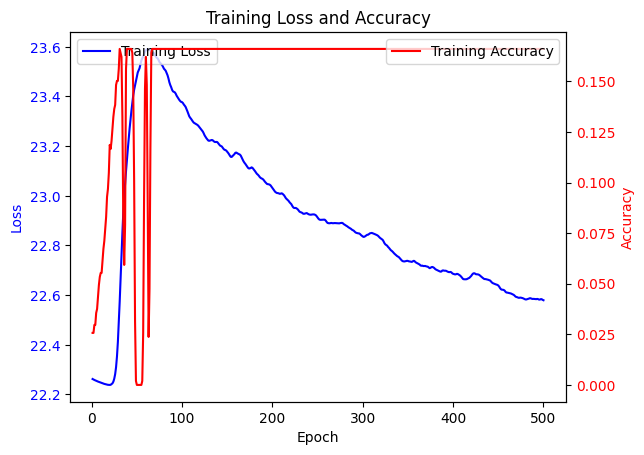

In [71]:
# Create a figure and axis for the loss plot
fig, ax1 = plt.subplots()

# Plot the training loss on the left y-axis
ax1.plot(range(1, len(training_loss) + 1), training_loss, label='Training Loss', color='b')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc='upper left')

# Create a second axis for the accuracy plot, sharing the same x-axis
ax2 = ax1.twinx()

# Plot the training accuracy on the right y-axis
ax2.plot(range(1, len(training_accuracy) + 1), training_accuracy, label='Training Accuracy', color='r')
ax2.set_ylabel('Accuracy', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc='upper right')

plt.title('Training Loss and Accuracy')
plt.show()